---
title: C++ 网络编程 socket Hello World
tags: 小书匠,c++,network,socket,bind,listen,accept
grammar_cjkRuby: true
renderNumberedHeading: true
---

[toc]

# C++ 网络编程 socket Hello World

socket 编程实际上就几个函数一些结构体。其他东西都很固定。

## 编程模式

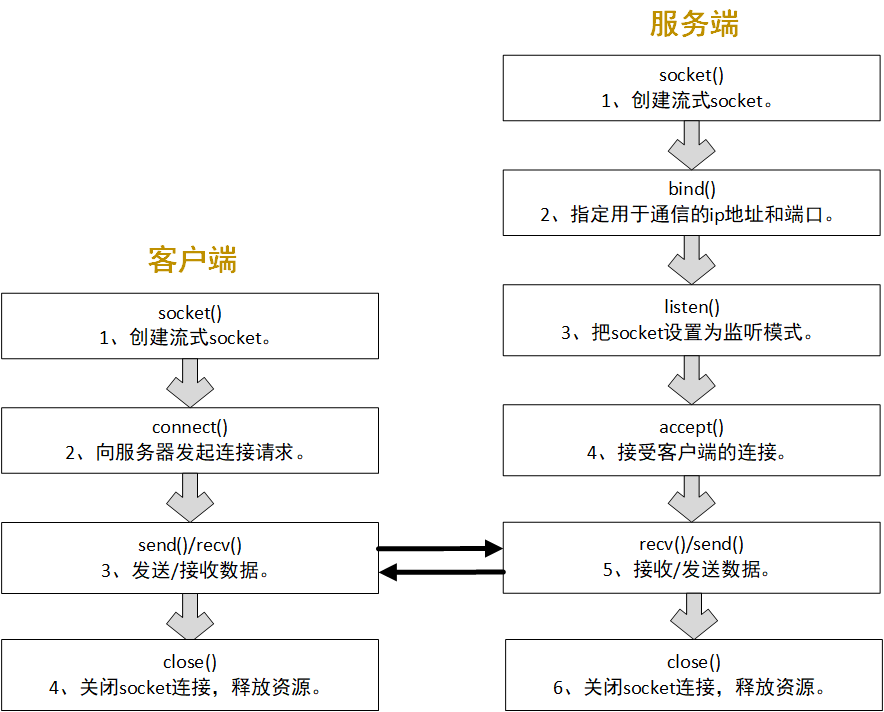

## 代码演示

### server.cpp

In [1]:
%%file server.cpp
#include <iostream>
#include <cstring> // for memset
#include <sys/socket.h>
#include <arpa/inet.h> // inet_addr
#include <netinet/in.h> // IPPROTO_TCP
#include <unistd.h>

int main() {
    int server_sock = socket(AF_INET, SOCK_STREAM, IPPROTO_TCP);

    // 定义 server 地址
    sockaddr_in server_addr; // 定义一个 sockaddr_in 对象
    memset(&server_addr, 0, sizeof(server_addr));
    server_addr.sin_family = AF_INET; // 使用 IPv4
    server_addr.sin_addr.s_addr = inet_addr("127.0.0.1"); //指定 ip
    server_addr.sin_port = htons(1234); // 指定端口
    
    // 绑定地址
    // 需要将 sockeaddr_in 对象转换为 sockaddr 对象
    bind(server_sock, (sockaddr*)&server_addr, sizeof(server_addr));

    listen(server_sock, 20);
    
    // 定义 client 地址
    sockaddr_in client_addr;
    socklen_t client_addr_size = sizeof(client_addr);
    // 接受服务端地址
    int client_sock = accept(server_sock, (sockaddr*)&client_addr, &client_addr_size);
    
    printf("Connect to Client %s\n", inet_ntoa(client_addr.sin_addr)); // 输出 client 的ip看看

    const char s[] = "hello world!"; // 服务器端发送给客户端 hello world!
    write(client_sock, s, sizeof(s));

    close(client_sock);
    close(server_sock);
    return 0;
}

Overwriting server.cpp


### client.cpp

In [49]:
%%file client.cpp
#include <iostream>
#include <unistd.h>
#include <arpa/inet.h>
#include <sys/socket.h>
#include <cstring>

int main()
{
    
    int serv_sock = socket(AF_INET, SOCK_STREAM, IPPROTO_TCP);
    
    sockaddr_in serv_addr;
    memset(&serv_addr, 0, sizeof(serv_addr));
    serv_addr.sin_family = AF_INET;
    serv_addr.sin_addr.s_addr = inet_addr("127.0.0.1");
    serv_addr.sin_port = htons(1234);
    
    connect(serv_sock, (sockaddr*)&serv_addr, sizeof(serv_addr));
    
    char buffer[400];
    read(serv_sock, buffer, sizeof(buffer)-1); // 从 server 中读取
    
    printf("Message from server %s\n", buffer);
    close(serv_sock);
    return 0;
}

Overwriting client.cpp


In [48]:
!g++ server.cpp -o server
!g++ client.cpp -o client

## 代码讲解

### bind

原型

```cpp
int bind(int sock, struct sockaddr *addr, socklen_t addrlen);  //Linux
```

### inet_addr

The inet_addr() function shall convert the string pointed to by cp, in the standard IPv4 dotted decimal notation, to an integer value suitable for use as an Internet address.

In [23]:
#include <arpa/inet.h>

inet_addr("127.0.0.1"); // 16777343

16777343

In [7]:
!g++ server.cpp -o server
!./server

### inet_ntoa

将 in_addr 转换为 str

In [47]:
#include <arpa/inet.h>

uint32_t ip = 2110443574;
in_addr ip_addr;
ip_addr.s_addr = ip;
printf("The IP address is %s\n", inet_ntoa(ip_addr));

The IP address is 54.208.202.125


### sockaddr_in 和 sockaddr

先给出结论：
sockaddr 是一种通用的结构体，可以用来保存多种类型的IP地址和端口号，而 sockaddr_in 是专门用来保存 IPv4 地址的结构体。可以认为，sockaddr_in 就是为了方便的定义 sockaddr 的。

程序员不应操作sockaddr，sockaddr是给操作系统用的，程序员应使用sockaddr_in来表示地址，sockaddr_in区分了地址和端口，使用更方便。 
因此，一般的使用方法是把类型、ip地址、端口填充sockaddr_in结构体，然后强制转换成sockaddr，作为参数传递给系统调用函数

#### sockaddr

sockaddr 的定义如下

```cpp
struct sockaddr{
    sa_family_t  sin_family;   //地址族（Address Family），也就是地址类型
    char         sa_data[14];  //IP地址和端口号
};
```

#### sockaddr_in

定义为这个样子

```cpp
struct sockaddr_in{
    sa_family_t     sin_family;   //地址族（Address Family），也就是地址类型
    uint16_t        sin_port;     //16位的端口号
    struct in_addr  sin_addr;     //32位IP地址
    char            sin_zero[8];  //不使用，一般用0填充
};
```

其中还用到了 in_addr 结构体，定义如下

```cpp
struct in_addr{
    in_addr_t  s_addr;  //32位的IP地址
};
```

而 in_addr_t 在头文件 <netinet/in.h> 中定义，等价于 unsigned long，长度为4个字节。

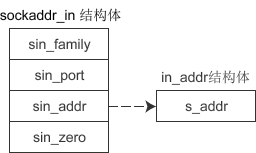

#### 为什么不直接sockaddr？而要用 sockaddr_in


下图给出了了 sockaddr 和 sockaddr_in 的大小

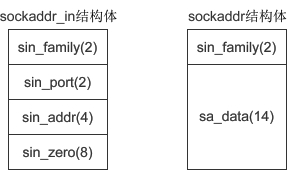

可以看到，sockaddr_in 和 sockaddr 的大小完全相同，因此可以进行强制类型转换将 sockaddr_in 转换成 sockaddr，sockaddr_in 中最后的 sin_zero 部分也正是为了将两个结构体大小填充相同以保证类型转换。

实际上，还有表示 ipv6 地址的结构体，定义如下。
```cpp
struct sockaddr_in6 { 
    sa_family_t sin6_family;  //(2)地址类型，取值为AF_INET6
    in_port_t sin6_port;  //(2)16位端口号
    uint32_t sin6_flowinfo;  //(4)IPv6流信息
    struct in6_addr sin6_addr;  //(4)具体的IPv6地址
    uint32_t sin6_scope_id;  //(4)接口范围ID
};
```
注释中注明了每个成员的大小，可以看到 sockaddr_in6 的大小也是 16个字节，和 sockaddr 相同，因为 sockaddr_in6 也是用来字节转换的。

### listen

对于服务器端程序，使用 bind() 绑定套接字后，还需要使用 listen() 函数让套接字**进入被动监听状态**，再调用 accept() 函数，就可以随时响应客户端的请求了。

sock 为需要进入监听状态的套接字，backlog 为请求队列的最大长度。

```cpp
int listen(int sock, int backlog);  //Linux
int listen(SOCKET sock, int backlog);  //Windows
```

listen() 只是让套接字进入监听状态，并没有真正接收客户端请求，**listen() 后面的代码会继续执行，直到遇到 accept()**。**accept() 会阻塞程序执行（后面代码不能被执行），直到请求到来**。

```cpp
int accept(int sock, struct sockaddr *addr, socklen_t *addrlen);  //Linux
SOCKET accept(SOCKET sock, struct sockaddr *addr, int *addrlen);  //Windows
```

### accept

accept 的原型如下

```cpp
int accept(int sock, struct sockaddr *addr, socklen_t *addrlen);  //Linux
SOCKET accept(SOCKET sock, struct sockaddr *addr, int *addrlen);  //Windows
```

处于监听状态的 socket 使用 accept 来接受请求。

- accept 返回一个 socket，并将客户端的地址写入，服务端使用这个 socket 和客户端通信。
- 如果失败，则返回-1, 错误原因存于errno 中.
- accept 接受一个 sockaddr*，它会将服务端的地址写入到这个指针指向的空间中，从而获得客户端的地址。

如果我们不需要客户端的地址，我们可以传入空指针

```cpp
accept(client_socket, 0, 0);
```

client 运行后，通过 connect() 函数向 server 发起请求，处于监听状态的 server 被激活，执行 accept() 函数，接受客户端的请求，然后执行 write() 函数向 client 传回数据。client 接收到传回的数据后，connect() 就运行结束了，然后使用 read() 将数据读取出来。

### 服务端有两个 socket 而客户端只有一个 socket

因为服务端是被动的，客户端是主动的。


- 客户端是主动的，客户端一开始就知道服务端的信息，因此它只需要建立一个服务端 socket，然后和这个 socket 读写通信就可以了。

- 但是，服务端是被动的，在客户端连接服务端之前，它不知道服务端的信息。因此，它只能启动一个 socket，让客户端去连接，连接的过程中服务端会得到客户端的信息，利用这个信息服务端可以建立客户端的 socket，通过这个 socket 和客户端通信。

这个过程有点类似于 server 和 client 想要互发邮件通讯，但是 server 不知道 client 的邮箱，而 client 知道 server 的邮箱。因此 client 就将自己的信息发送到 server 的邮箱中。server 通过读取自己的邮箱，获取到 client 的邮件地址，然后再给 client 发邮件。

### write 和 read

linux 中所有都是文件，因此它并不区分普通文件和 socket 文件，可以使用统一的函数 read 和 write 去进行读写。

同时，还可以使用 send 和 recv 来进行网络请求，send 和 recv 提供了第四个参数来控制读写行为，一般不用管。

### TCP 三次握手和 accept 的关系

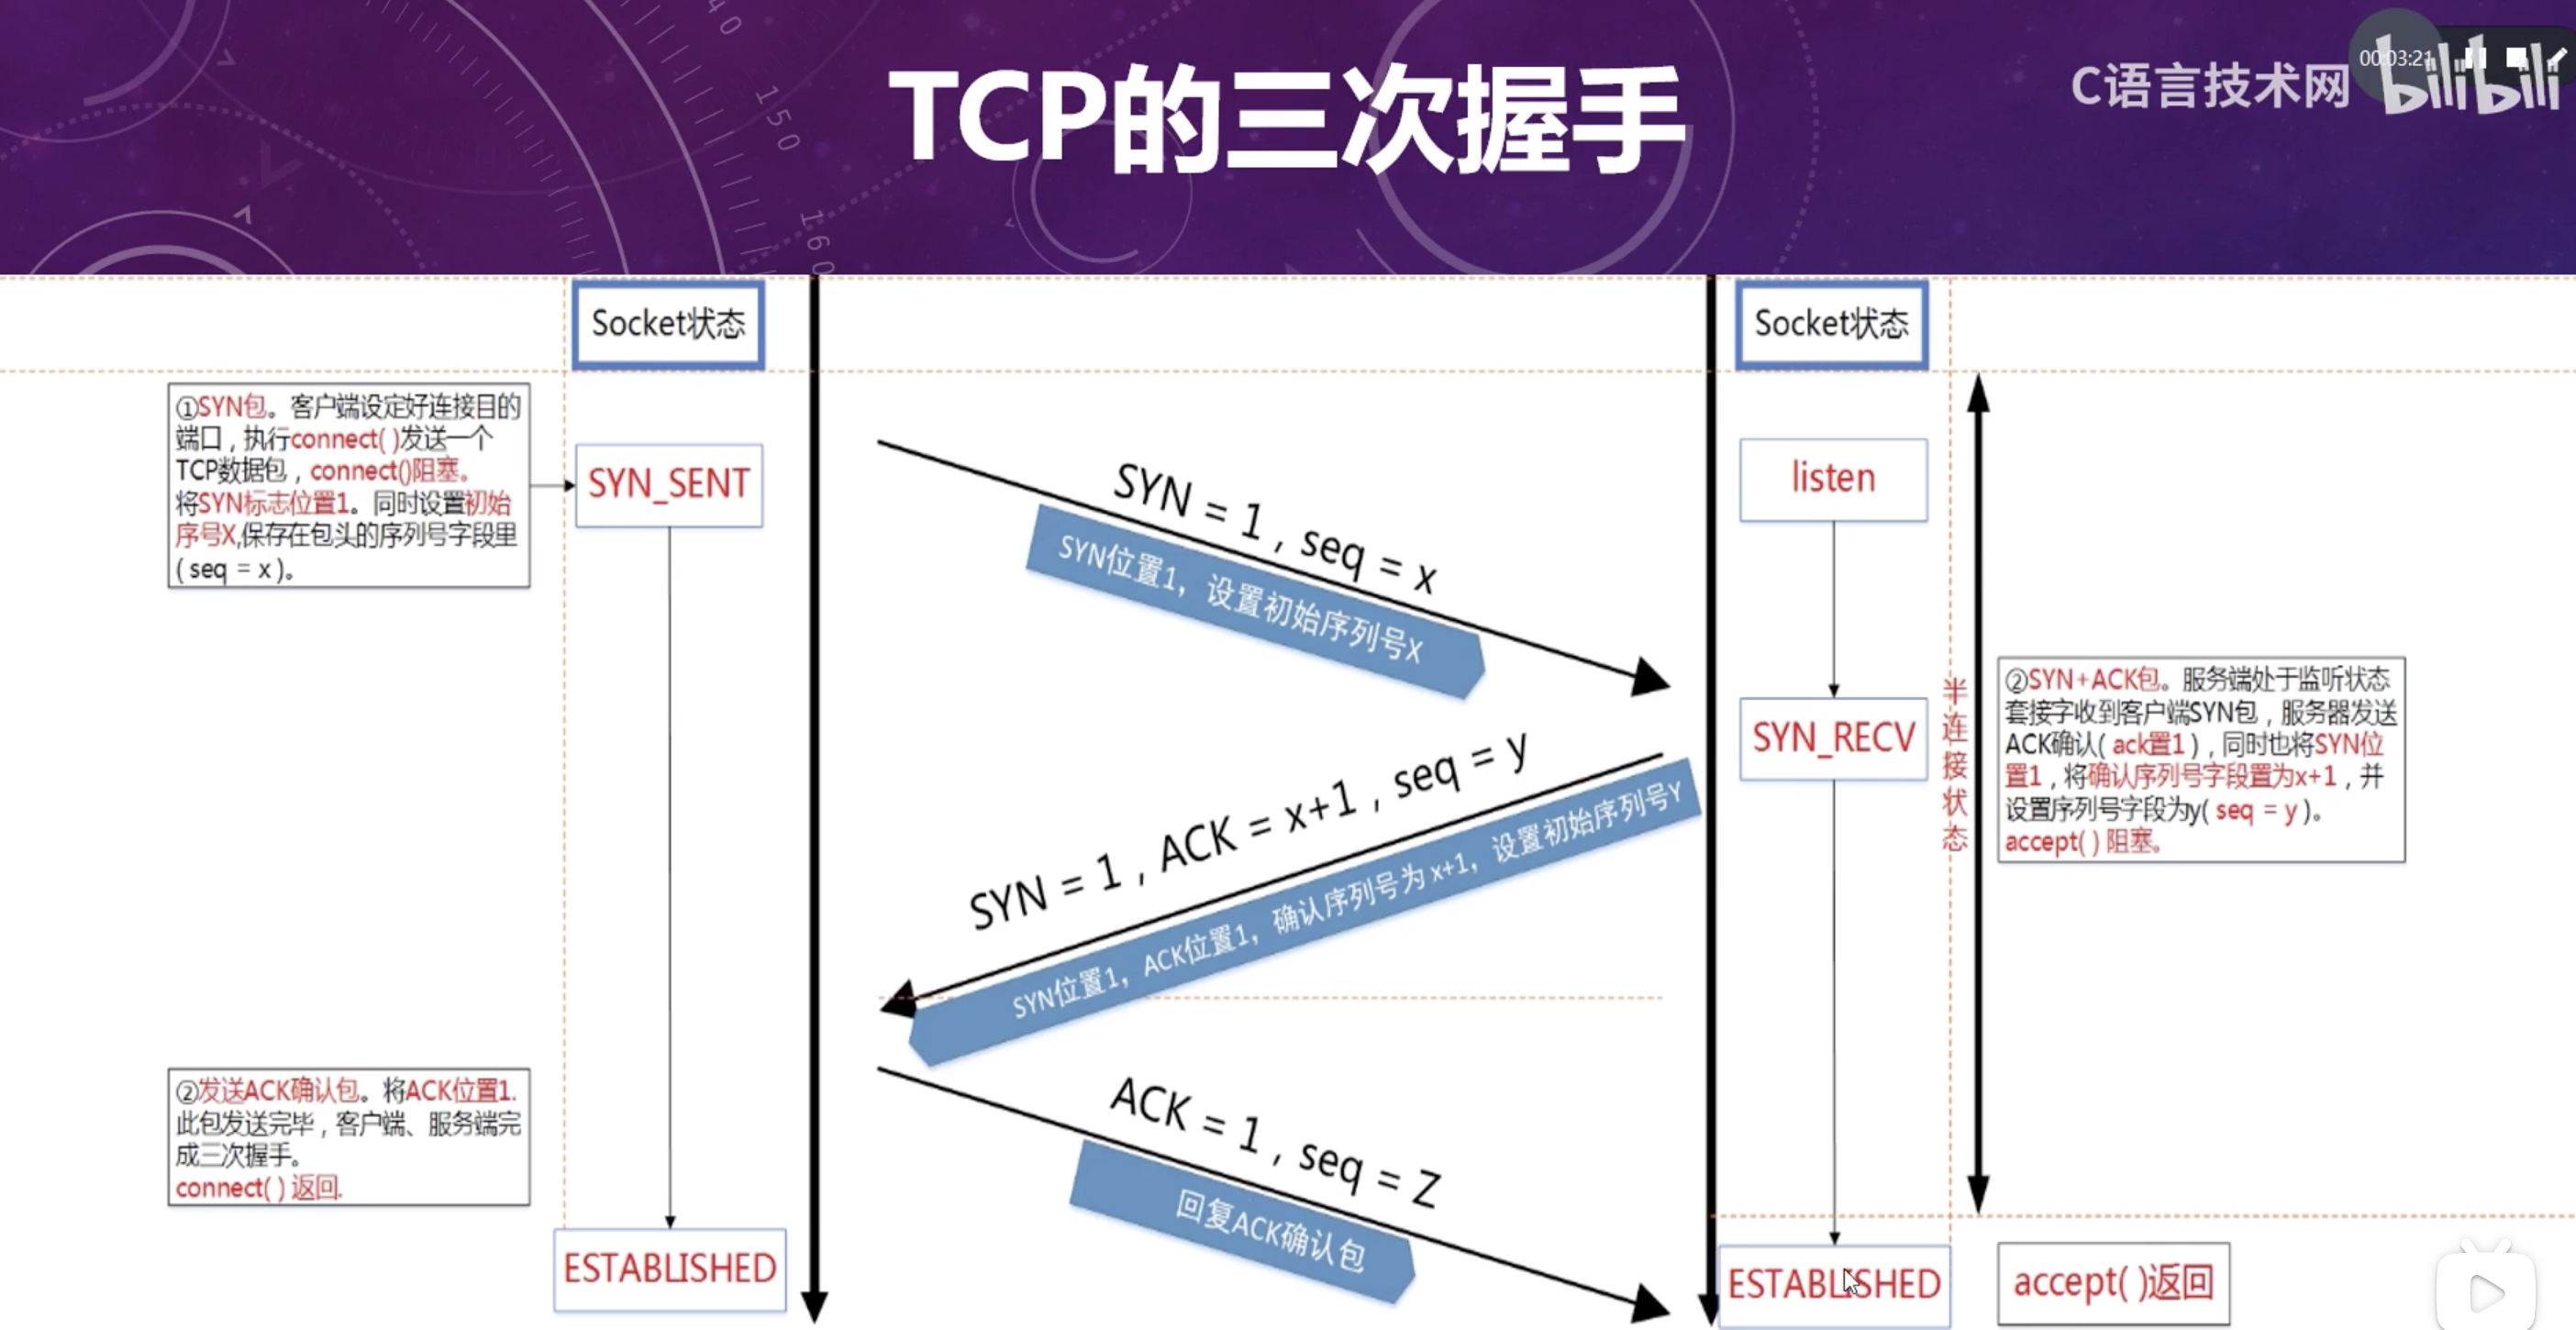

可以看到被动监听的 socket 存在两个状态，SYN_RECV 状态，和 ESTABLISHED 状态。

由于服务端可以连接多个客户端，因此需要用队列来保存不同的客户端 socket。由于有两个状态，因此有两个队列，一个 SYN_RECV 队列，一个 ESTABLISHIED 队列。我们在 listen 中使用的 backlog 参数是 ESTABLISHED 状态的 socket 个数。具体可以看 [listen(2) - Linux manual page](https://man7.org/linux/man-pages/man2/listen.2.html)

同时，客户端在发送完 ACK 包之后就认为连接建立成功进入 ESTABLISHED 状态了，而服务端此时不一定是 ESTABLISHED 状态，还有可能是 SYN_RECV 状态。

accept 的作用实际上是从 ESTABLISHED 队列中获取一个 socket

# References 

- [网络通信基础socket](https://www.freecplus.net/0047ac4059b14d52bcc1d4df6ae8bb83.html)
- [一个简单的Linux下的socket程序_C语言中文网](http://c.biancheng.net/cpp/html/3030.html)
- [Linux C中sockaddr和sockaddr_in的区别_linux shell_脚本之家](https://www.jb51.net/article/117902.htm)
- [使用bind()和connect()函数_C语言中文网](http://c.biancheng.net/cpp/html/3033.html)
- 这个对于 tcp 和 socket 介绍比较多[C/C++网络编程，从socket到epoll_哔哩哔哩 (゜-゜)つロ 干杯~-bilibili](https://www.bilibili.com/video/BV11Z4y157RY?p=11)